***
# Starting Kit - Black Swan HiggsML Course
***

In [1]:
COLAB = "google.colab" in str(get_ipython())

In [2]:
if COLAB:
    ! git clone --depth 1 https://github.com/blackSwanCS/Higgs_collaborations.git

    ! git status
    %cd Higgs_collaborations

In [3]:
# HiggsML utility package should not be modified
# %pip install HiggsML
# %pip install xgboost

In [4]:
# !pip install mlflow

In [5]:
import sys
print(sys.executable)

c:\ProgramData\anaconda3\python.exe


### Imports

In [6]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys
import mlflow
import mlflow.keras

warnings.filterwarnings("ignore")

### Directories

In [7]:
!pip install iminuit

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import os
import sys

# Get root and submission directories
root_dir = os.getcwd()
print("Root directory is", root_dir)

submission_dir = os.path.join(root_dir, "sample_code_submission")

# The directory where results will be written
output_dir = os.path.join(root_dir, "sample_result_submission")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Add submission directory to sys.path
sys.path.append(submission_dir)

# Now import the model
from model import Model


Root directory is c:\Users\Abdullah Jamal\Desktop\College\Summers\Third Summer Training\HiggsProject\Higgs_collaborations


## Import Submission Model
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements a basic model with 2 different model trained to predict the class label. 

* 1 XGBoost BDT ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/boosted_decision_tree.py) )
* 2 Tebsorflow NN  ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/neural_network.py) )

The feature engineering is in where you can include derived quantities and decide which feature should be needed. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/feature_engineering.py) ) 

the statistical analysis part is where yoiu write the mu finding calculation using the output of the classifier. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/statistical_analysis.py) ) 

If running in Collab, click the folder icon in the left sidebar to open the file browser.


## Data
### Available data sets
1. blackSwan_data
2. sample_data
3. neurips2024_data 

In [9]:
from HiggsML.datasets import download_dataset

data = download_dataset(
    "blackSwan_data"
)  # change to "blackSwan_data" for the actual data

2025-07-28 16:59:37,199 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-07-28 16:59:37,200 - HiggsML.datasets     - INFO     - Current working directory: c:\Users\Abdullah Jamal\Desktop\College\Summers\Third Summer Training\HiggsProject\Higgs_collaborations
2025-07-28 16:59:37,202 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-07-28 16:59:37,202 - HiggsML.datasets     - INFO     - Test size: 600000


### ⚠️ Note:
The data used here is a small subset of the full data is for demonstration only to get a view of what the data looks like. 

In [10]:
# load train set
data.load_train_set()
data_set = data.get_train_set()

2025-07-28 16:59:37,320 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-07-28 16:59:38,006 - HiggsML.datasets     - INFO     - Data loaded successfully


***
## Visualize the Data Set
***

In [11]:
from tabulate import tabulate

target = data_set["labels"]
weights = data_set["weights"]
detailed_label = data_set["detailed_labels"]
keys = np.unique(detailed_label)


weight_keys = {}
average_weights = {}
for key in keys:
    weight_keys[key] = weights[detailed_label == key]

table_data = []
for key in keys:
    table_data.append(
        [
            key,
            np.sum(weight_keys[key]),
            len(weight_keys[key]),
            np.mean(weight_keys[key]),
        ]
    )

table_data.append(
    [
        "Total Signal",
        np.sum(weights[target == 1]),
        len(weights[target == 1]),
        np.mean(weights[target == 1]),
    ]
)
table_data.append(
    [
        "Total Background",
        np.sum(weights[target == 0]),
        len(weights[target == 0]),
        np.mean(weights[target == 0]),
    ]
)


print("[*] --- Detailed Label Summary")
print(
    tabulate(
        table_data,
        headers=[
            "Detailed Label",
            "Total Weight",
            "Number of events",
            "Average Weight",
        ],
        tablefmt="grid",
    )
)

[*] --- Detailed Label Summary
+------------------+----------------+--------------------+------------------+
| Detailed Label   |   Total Weight |   Number of events |   Average Weight |
+==================+================+====================+==================+
| diboson          |        382.109 |               3406 |       0.112187   |
+------------------+----------------+--------------------+------------------+
| htautau          |        675.897 |             462981 |       0.00145988 |
+------------------+----------------+--------------------+------------------+
| ttbar            |       4404.72  |              39293 |       0.112099   |
+------------------+----------------+--------------------+------------------+
| ztautau          |     100256     |             894320 |       0.112103   |
+------------------+----------------+--------------------+------------------+
| Total Signal     |        675.897 |             462981 |       0.00145988 |
+------------------+-------------

In [12]:
print("\n[*] --- Examples of all features\n")
display(data_set.head())


[*] --- Examples of all features



,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,37.472000,0.676,-1.520,46.752998,0.623,1.500,-25.000000,-25.000,-25.000,-25.000,...,30.256184,-25.000,-25.000000,-25.000000,3.020465,30.256184,84.224998,0.801489,1.365776,-25.000000
1,26.006001,-0.087,-1.412,60.009998,-0.290,-0.099,134.770996,0.350,2.894,49.673,...,124.359779,2.009,232.705902,-0.580650,1.328600,9.316307,270.459991,0.433361,1.413247,0.726747
2,20.622999,-0.922,-0.436,41.917999,-1.356,2.524,-25.000000,-25.000,-25.000,-25.000,...,10.601603,-25.000,-25.000000,-25.000000,2.991648,10.601603,62.541000,0.491984,1.315526,-25.000000
3,48.394001,0.202,0.816,27.916000,-0.552,-2.387,-25.000000,-25.000,-25.000,-25.000,...,10.455322,-25.000,-25.000000,-25.000000,3.171129,10.455322,76.309998,1.733558,-1.409702,-25.000000
4,39.840000,-0.005,1.487,30.997000,1.747,2.681,73.082001,3.369,-1.286,31.274,...,92.074677,3.370,254.889191,-0.003369,2.120175,6.207835,175.192993,1.285286,1.037429,0.366135


In [13]:
print("\n[*] --- Description of all features\n")
display(data_set.describe())


[*] --- Description of all features



,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,...,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06
mean,3.396482e+01,-1.664071e-03,3.532688e-04,4.310186e+01,-1.059442e-03,-7.431224e-04,2.039557e+01,-1.315356e+01,-1.315217e+01,-8.396195e+00,...,4.182135e+01,-1.887505e+01,5.100177e+01,-1.941999e+01,2.738726e+00,1.806350e+01,1.273698e+02,8.796806e-01,2.691063e-01,-1.930729e+01
std,1.805632e+01,1.223061e+00,1.812455e+00,2.133130e+01,1.245722e+00,1.813313e+00,6.295906e+01,1.259517e+01,1.258585e+01,3.418907e+01,...,5.430045e+01,1.150126e+01,2.375393e+02,1.052948e+01,6.101729e-01,1.600541e+01,1.093643e+02,5.091473e-01,1.215709e+00,1.053709e+01
min,2.000000e+01,-2.500000e+00,-3.142000e+00,2.287700e+01,-2.690000e+00,-3.142000e+00,-2.500000e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,...,1.173875e-02,-2.500000e+01,-2.500000e+01,-2.500000e+01,5.641427e-01,1.173875e-02,4.304400e+01,3.400616e-02,-1.414214e+00,-2.500000e+01
25%,2.395100e+01,-9.520000e-01,-1.568000e+00,3.077000e+01,-9.770000e-01,-1.572000e+00,-2.500000e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,...,1.094507e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,2.509546e+00,8.491425e+00,6.449300e+01,5.891082e-01,-1.332358e+00,-2.500000e+01
50%,2.901600e+01,-1.000000e-03,1.000000e-03,3.816800e+01,-1.000000e-03,3.000000e-03,-2.500000e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,...,2.156595e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,2.957897e+00,1.439308e+01,8.531300e+01,7.759828e-01,9.866624e-01,-2.500000e+01
75%,3.716600e+01,9.500000e-01,1.572000e+00,4.813200e+01,9.730000e-01,1.570000e+00,4.706200e+01,-1.560000e-01,-1.780000e-01,-2.500000e+01,...,4.885020e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,3.127119e+00,2.271586e+01,1.433570e+02,1.024202e+00,1.385667e+00,-2.500000e+01
max,1.101770e+03,2.500000e+00,3.142000e+00,8.452980e+02,2.680000e+00,3.142000e+00,1.203860e+03,4.991000e+00,3.142000e+00,1.001000e+03,...,1.175087e+03,9.666000e+00,6.555388e+03,2.229731e+01,5.804204e+00,7.199706e+02,2.497039e+03,2.160489e+01,1.414214e+00,1.000000e+00


In [14]:
print("\n[*] --- Labels vs. Detailed Labels\n")
display(data_set[["labels", "detailed_labels"]].head(70))


[*] --- Labels vs. Detailed Labels



,labels,detailed_labels
0,1.0,htautau
1,0.0,ztautau
2,0.0,ztautau
3,1.0,htautau
4,1.0,htautau
...,...,...
65,1.0,htautau
66,1.0,htautau
67,0.0,ztautau
68,0.0,ztautau


In [15]:
# !pip install mplhep

[*] --- PRI_lep_phi histogram
[*] --- PRI_met histogram
[*] --- DER_mass_vis histogram
[*] --- DER_deltaeta_jet_jet histogram


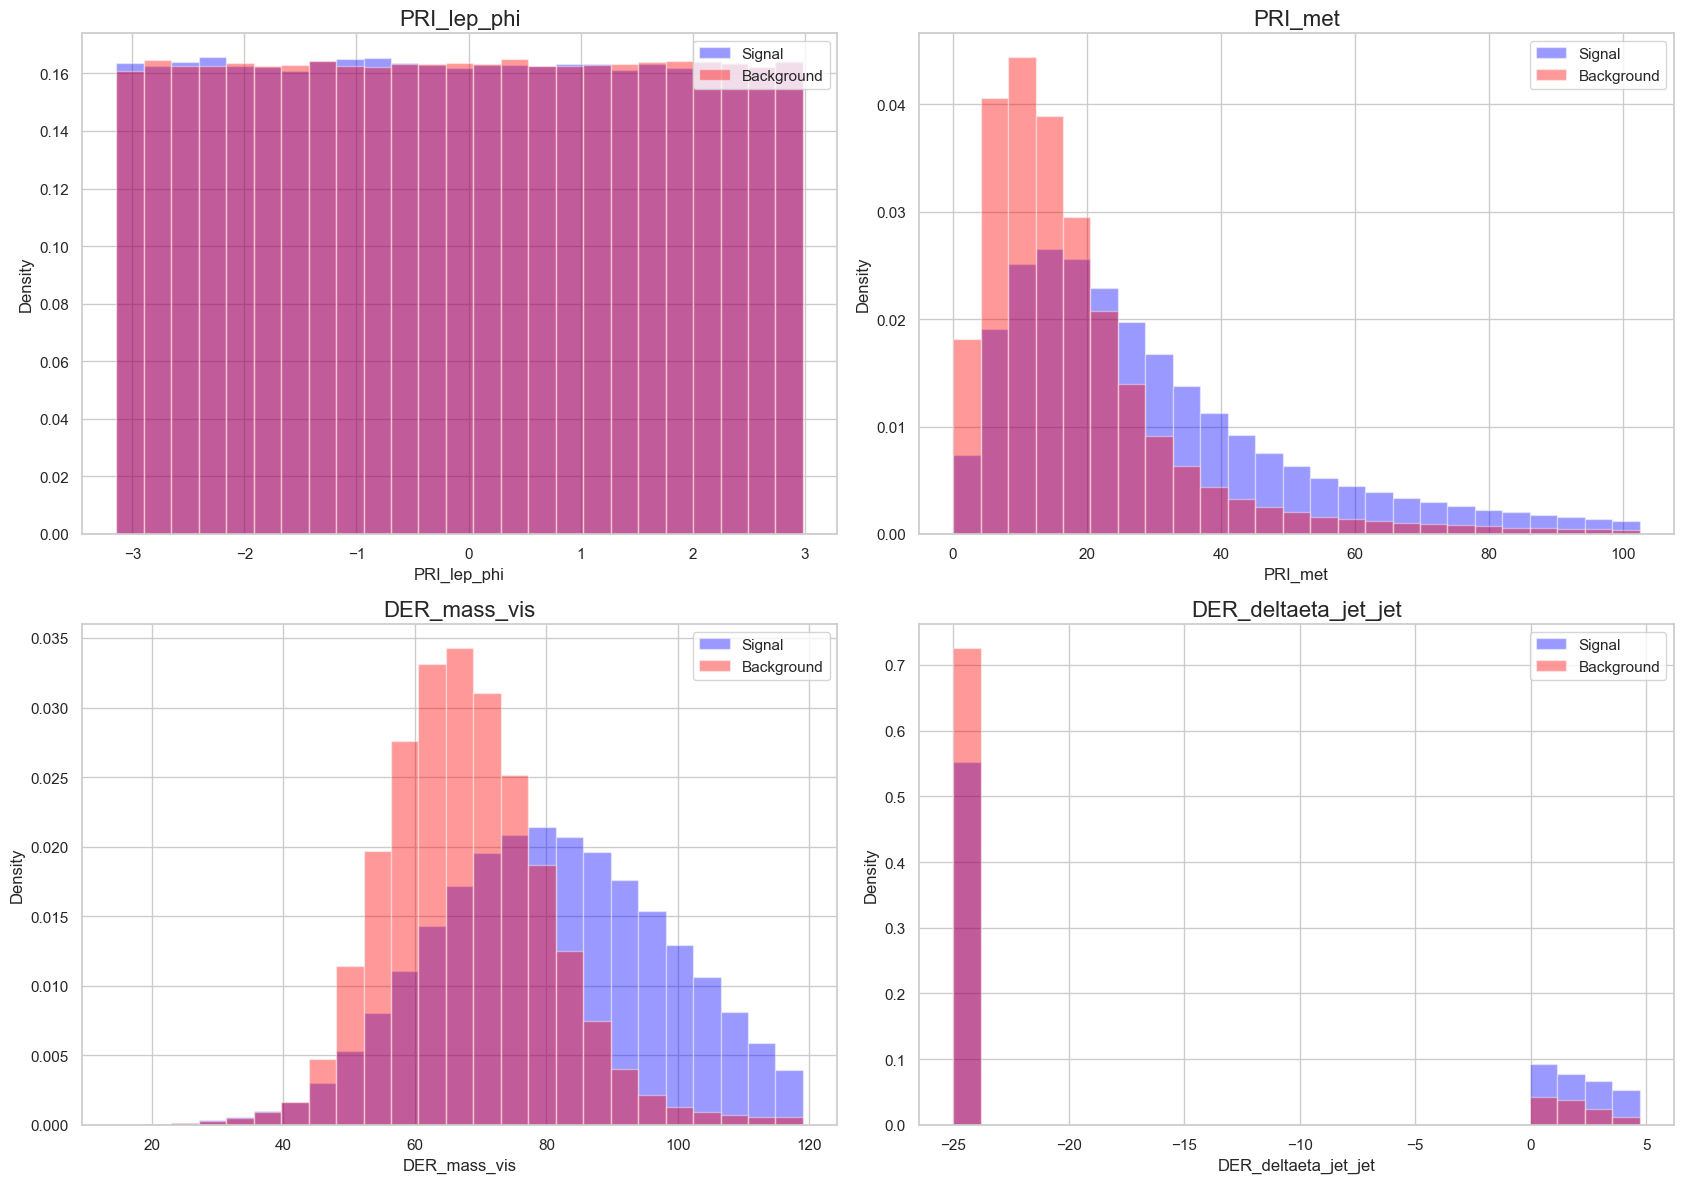

'histogram.png'

In [16]:
from utils import histogram_dataset

# this function is defined in utils.py in the sample_code_submission directory. feel free to modify it as needed

histogram_dataset(
    data_set,
    target,
    weights,
    columns=["PRI_lep_phi", "PRI_met", "DER_mass_vis", "DER_deltaeta_jet_jet"],
)

Signal feature  correlation matrix


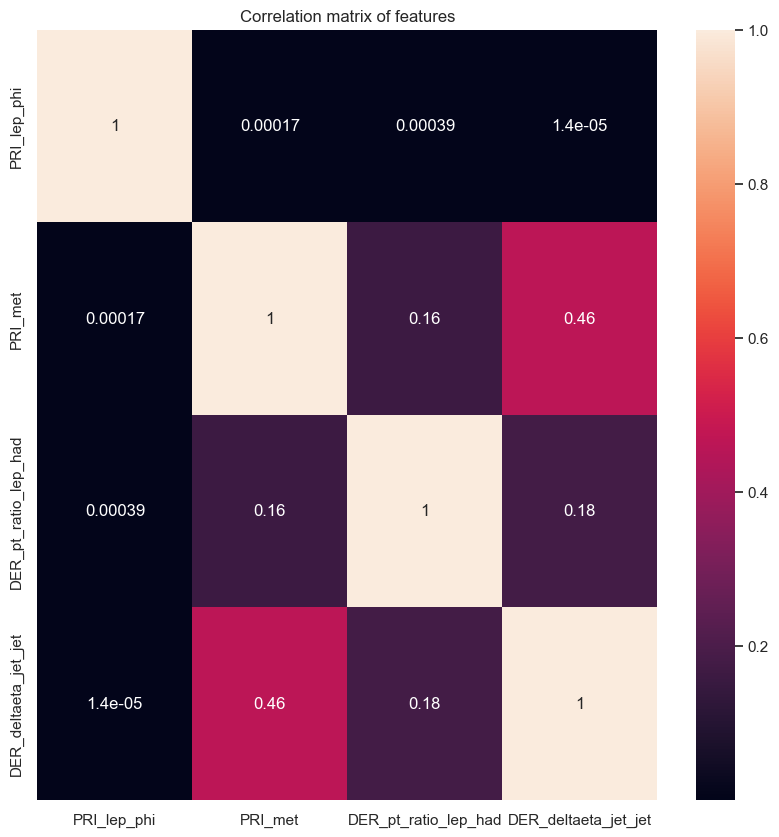

Background feature  correlation matrix


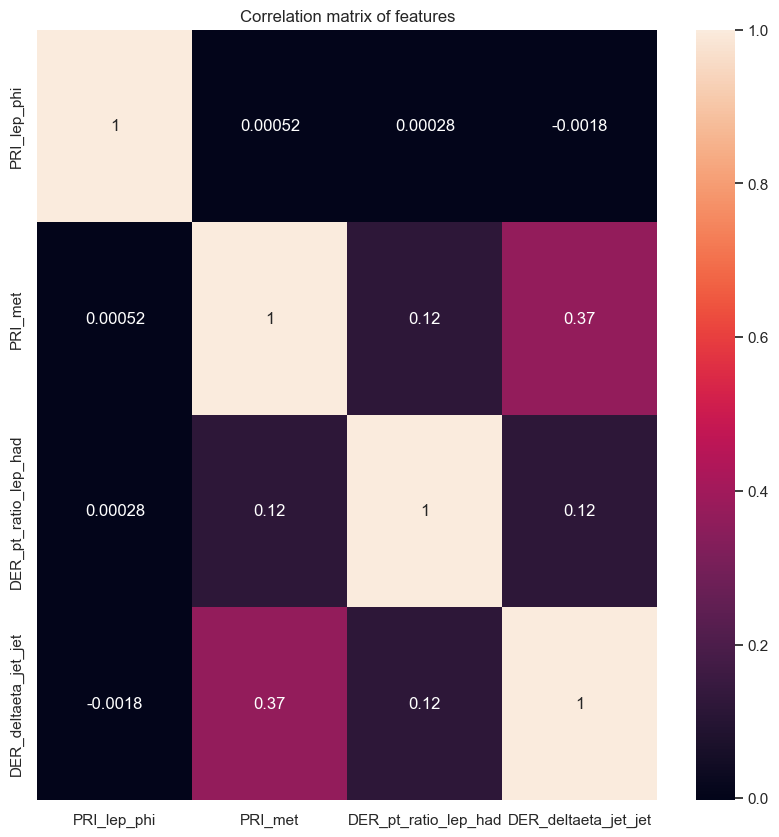

In [17]:
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (10, 10)}, style="whitegrid")

caption = ["Signal feature", "Background feature"]

for i in range(2):

    dfplot = pd.DataFrame(
        data_set,
        columns=[
            "PRI_lep_phi",
            "PRI_met",
            "DER_pt_ratio_lep_had",
            "DER_deltaeta_jet_jet",
        ],
    )

    print(caption[i], " correlation matrix")
    corrMatrix = dfplot[target == i].corr()
    sns.heatmap(corrMatrix, annot=True)
    plt.title("Correlation matrix of features")
    plt.show()

del dfplot

keys ['diboson' 'htautau' 'ttbar' 'ztautau']
keys 2 dict_keys(['diboson', 'htautau', 'ttbar', 'ztautau'])
htautau (30,)


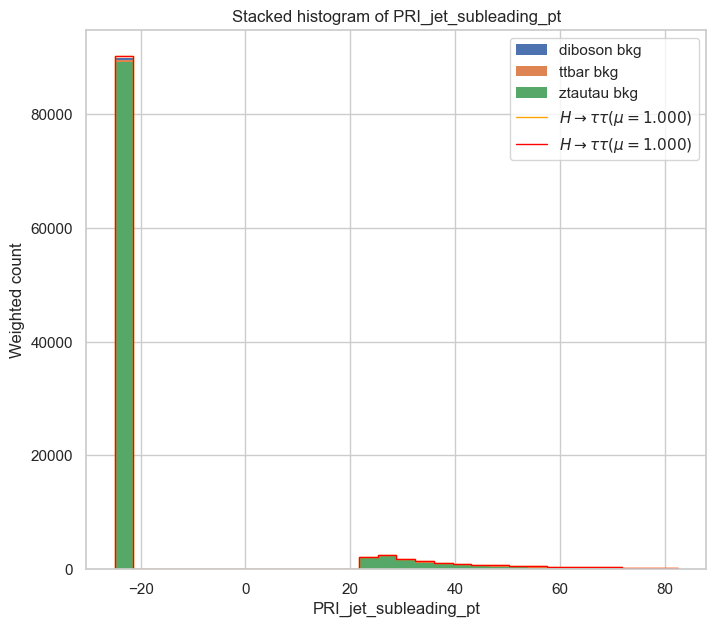

In [18]:
from HiggsML.visualization import stacked_histogram

stacked_histogram(data_set, target, weights, detailed_label, "PRI_jet_subleading_pt")

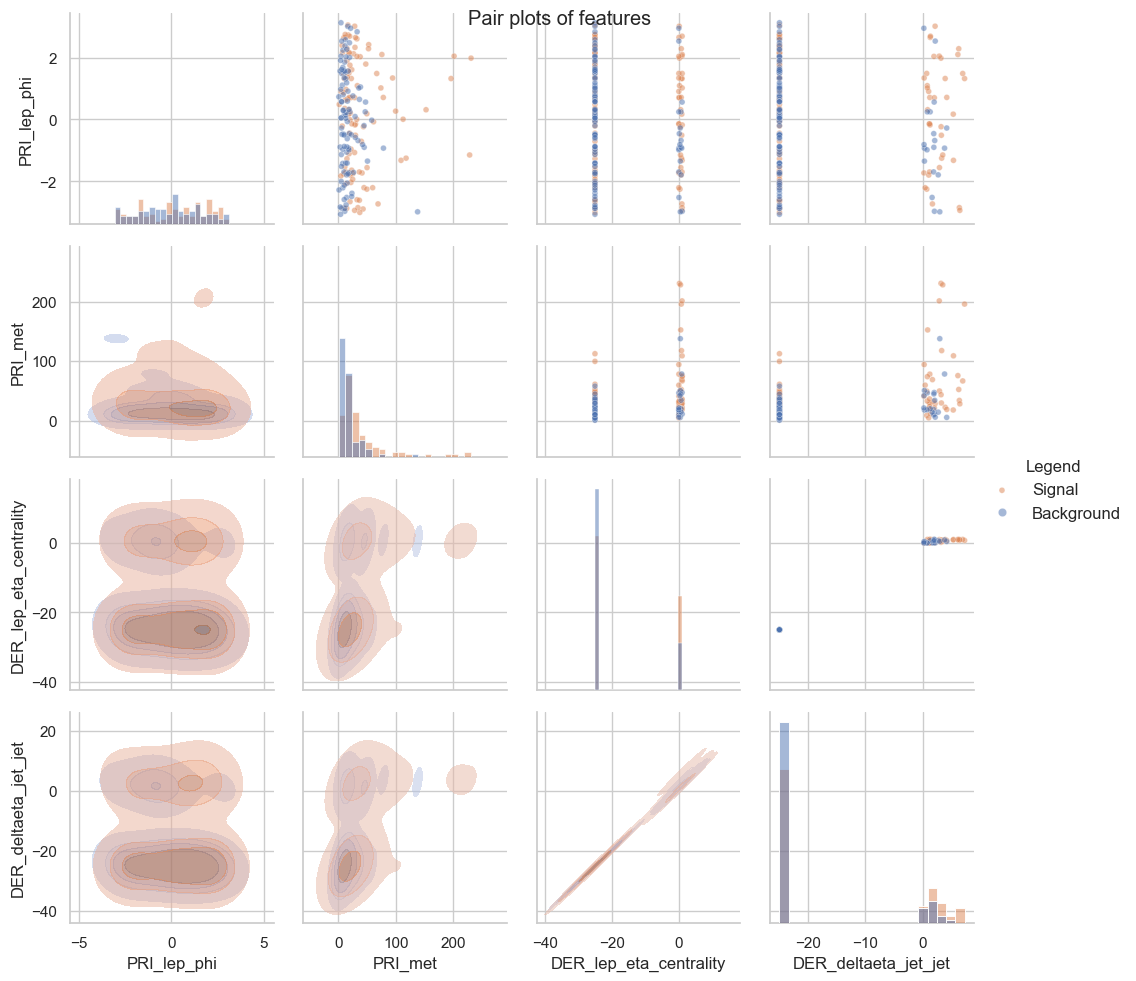

In [19]:
from HiggsML.visualization import pair_plots

# Show data summary
pair_plots(
    data_set,
    target,
    sample_size=100,
    columns=[
        "PRI_lep_phi",
        "PRI_met",
        "DER_lep_eta_centrality",
        "DER_deltaeta_jet_jet",
    ],
)

### Ingestion



Ingestion is part of your competition framework (from HiggsML.ingestion). Its job is to:

| Responsibility                   | Explanation                                                |
| -------------------------------- | ---------------------------------------------------------- |
| Standardize model interface      | Calls `Model.__init__`, `fit`, `predict` with correct args |
| Pass dataset correctly           | Gives your model access to `get_train_set()`               |
| Enforce submission rules         | Checks naming, format, timing, and required outputs        |
| Log outputs and monitor training | Might save logs, errors, or performance                    |
| Run evaluation (sometimes)       | Possibly computes metrics like `mu_hat` or AUC             |


In [20]:
from HiggsML.ingestion import Ingestion

ingestion = Ingestion(data)

In [21]:
# initialize submission
ingestion.init_submission(Model,"NN")

2025-07-28 16:59:48,059 - HiggsML.ingestion    - INFO     - Initializing Submmited Model
2025-07-28 16:59:48,129 - HiggsML.datasets     - INFO     - Selected train size: 500000
2025-07-28 16:59:48,538 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-07-28 16:59:48,619 - HiggsML.datasets     - INFO     - Selected train size: 500000


Training Data:  (500000, 28)
Training Labels:  (500000,)
Training Weights:  (500000,)
sum_signal_weights:  678.5112845898027
sum_bkg_weights:  105040.48871541017


2025-07-28 16:59:49,054 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-07-28 16:59:49,132 - HiggsML.datasets     - INFO     - Selected train size: 400000



Valid Data:  (500000, 28)
Valid Labels:  (500000,)
Valid Weights:  (500000,)
sum_signal_weights:  677.0425023673389
sum_bkg_weights:  105041.95749763264


2025-07-28 16:59:49,544 - HiggsML.datasets     - INFO     - Data loaded successfully



Holdout Data:  (400000, 28)
Holdout Labels:  (400000,)
Holdout Weights:  (400000,)
sum_signal_weights:  671.2116955780178
sum_bkg_weights:  105047.78830442199
 
 
Training Data:  (500000, 28)
DEBUG: model_type = 'NN'
 Model is NN


In [22]:
# fit submission
ingestion.fit_submission()

2025-07-28 16:59:49,754 - HiggsML.ingestion    - INFO     - Calling fit method of submitted model


Epoch 1/30
12500/12500 - 331s - 27ms/step - accuracy: 0.7894 - loss: 0.2057 - val_accuracy: 0.8048 - val_loss: 0.1921 - learning_rate: 0.0010
Epoch 2/30
12500/12500 - 345s - 28ms/step - accuracy: 0.8021 - loss: 0.1967 - val_accuracy: 0.8136 - val_loss: 0.1897 - learning_rate: 0.0010
Epoch 3/30
12500/12500 - 339s - 27ms/step - accuracy: 0.8054 - loss: 0.1945 - val_accuracy: 0.8220 - val_loss: 0.1917 - learning_rate: 0.0010
Epoch 4/30
🏃 View run NN - all featurse at: http://127.0.0.1:5000/#/experiments/571065933507312880/runs/8b25a82120924ef093d690763b28d7ce
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/571065933507312880


KeyboardInterrupt: 

In [ ]:
# load test set
data.load_test_set()

2025-07-28 16:51:29,426 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-07-28 16:51:29,675 - HiggsML.datasets     - INFO     - Test data loaded successfully


### Test Settings
The Test setting sets the test conditions in ingestion.
This includes what systematics you want and how many psuedo experiments you want. 

In [ ]:
test_settings = {
    "systematics": {  # Systematics to use
        "tes": False,  # tau energy scale
        "jes": False,  # jet energy scale
        "soft_met": False,  # soft term in MET
        "ttbar_scale": False,  # W boson scale factor
        "diboson_scale": False,  # Diboson scale factor
        "bkg_scale": False,  # Background scale factor
    },
    "num_pseudo_experiments": 20,  # Number of pseudo-experiments to run per set
    "num_of_sets": 1,  # Number of sets of pseudo-experiments to run.
}

RANDOM_SEED = 42

random_state = np.random.RandomState(RANDOM_SEED)
test_settings["ground_truth_mus"] = (
    random_state.uniform(0.1, 3, test_settings["num_of_sets"])
).tolist()

random_settings_file = os.path.join(output_dir, "test_settings.json")
with open(random_settings_file, "w") as f:
    json.dump(test_settings, f)

In [ ]:
# predict submission
ingestion.predict_submission(test_settings)

2025-07-28 16:51:29,704 - HiggsML.ingestion    - INFO     - Calling predict method of submitted model with seed: 31415


Test Results:  {'mu_hat': -1.3418849301274356, 'del_mu_stat': 0.24416644361471201, 'del_mu_sys': 0.0, 'del_mu_tot': 0.24416644361471201}
Test Results:  {'mu_hat': -0.9137077765045328, 'del_mu_stat': 0.24416644361471201, 'del_mu_sys': 0.0, 'del_mu_tot': 0.24416644361471201}
Test Results:  {'mu_hat': -1.0506473166271728, 'del_mu_stat': 0.24416644361471201, 'del_mu_sys': 0.0, 'del_mu_tot': 0.24416644361471201}
Test Results:  {'mu_hat': -1.5829756697799708, 'del_mu_stat': 0.24416644361471201, 'del_mu_sys': 0.0, 'del_mu_tot': 0.24416644361471201}
Test Results:  {'mu_hat': -0.9754270058555818, 'del_mu_stat': 0.24416644361471201, 'del_mu_sys': 0.0, 'del_mu_tot': 0.24416644361471201}
Test Results:  {'mu_hat': -1.1046516423093409, 'del_mu_stat': 0.24416644361471201, 'del_mu_sys': 0.0, 'del_mu_tot': 0.24416644361471201}
Test Results:  {'mu_hat': -0.9792844576900224, 'del_mu_stat': 0.24416644361471201, 'del_mu_sys': 0.0, 'del_mu_tot': 0.24416644361471201}
Test Results:  {'mu_hat': -0.917565228338

In [ ]:
ingestion.process_results_dict()

In [ ]:
# save result
ingestion.save_result(output_dir)

## Score
1. Compute Scores
2. Visualize Scores


In [ ]:
from HiggsML.score import Scoring

In [ ]:
# Initialize Score
score = Scoring()

In [ ]:
print(output_dir)
score.load_ingestion_results(prediction_dir=output_dir, score_dir=output_dir)

2025-07-28 16:51:36,451 - HiggsML.score        - INFO     - Read ingestion results from c:\Users\Abdullah Jamal\Desktop\College\Summers\Third Summer Training\HiggsProject\Higgs_collaborations\sample_result_submission


c:\Users\Abdullah Jamal\Desktop\College\Summers\Third Summer Training\HiggsProject\Higgs_collaborations\sample_result_submission


In [ ]:
# !pip install pydot graphviz

In [ ]:
from utils import visualize_model_architecture
from neural_network import NeuralNetwork
from HiggsML.datasets import download_dataset

# Load dataset
data = download_dataset("blackSwan_data")
data.load_train_set()
data_set = data.get_train_set()

X_train = data_set.iloc[:, :-1]  # Features only

model_instance = NeuralNetwork(X_train)
visualize_model_architecture(model_instance.model, filename="nn_architecture.png")


2025-07-28 16:51:36,482 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-07-28 16:51:36,484 - HiggsML.datasets     - INFO     - Current working directory: c:\Users\Abdullah Jamal\Desktop\College\Summers\Third Summer Training\HiggsProject\Higgs_collaborations
2025-07-28 16:51:36,486 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-07-28 16:51:36,487 - HiggsML.datasets     - INFO     - Test size: 600000
2025-07-28 16:51:36,643 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-07-28 16:51:37,378 - HiggsML.datasets     - INFO     - Data loaded successfully


[✔] Saved model visualization to: nn_architecture.png


In [ ]:
import os
print("Current notebook working directory:", os.getcwd())


Current notebook working directory: c:\Users\Abdullah Jamal\Desktop\College\Summers\Third Summer Training\HiggsProject\Higgs_collaborations


2025-07-28 16:51:39,102 - HiggsML.score        - INFO     - Computing scores


[✔]


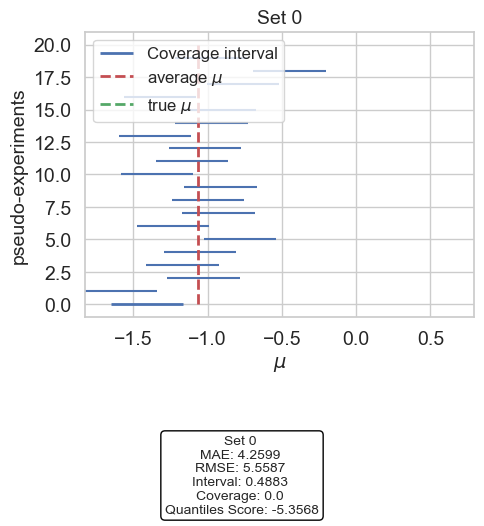

In [ ]:
# Compute Score
score.compute_scores(test_settings)

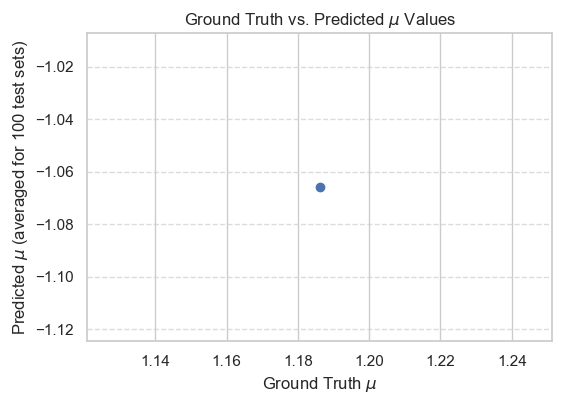

In [ ]:
from HiggsML.visualization import visualize_scatter

# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(
    ingestion_result_dict=ingestion.results_dict,
    ground_truth_mus=test_settings["ground_truth_mus"],
)

In [ ]:
!python -m HiggsML.score --prediction $output_dir --output $output_dir

############################################
### Scoring Program
############################################



usage: score.py [-h] [--prediction PREDICTION] [--output OUTPUT]
                [--reference REFERENCE] [--codabench]
score.py: error: unrecognized arguments: Jamal\Desktop\College\Summers\Third Summer Training\HiggsProject\Higgs_collaborations\sample_result_submission Jamal\Desktop\College\Summers\Third Summer Training\HiggsProject\Higgs_collaborations\sample_result_submission
